# Solvation and Absolute Free Energy Calculations of Alanine Dipeptide Conformations

## 1.1. Absolute Free Energy Definition

Consider the definition of a parition function $Z$ for a molecular dynamics system and Helmholtz free energy $F(N, V, T)$.

$$Z = \int \int e^{-\beta H(\vec{r}, \vec{p})} \,d\vec{r} d\vec{p}$$

$$F = -\frac{\ln Z}{\beta} $$

However, typically free energy calculations usually only involve finding the free energy $Z_r$ due to configurations, since the equiparition theorem makes finding the $Z_p$ very easy.

$$H(\vec{r}, \vec{p}) = U(\vec{r}) + K(\vec{p})$$

$$Z = \int e^{-\beta V(\vec{r})} d\vec{r} \cdot \int e^{-\beta K(\vec{p})}d\vec{p}$$

$$Z = Z_r \cdot Z_p$$

Of course, the integral $$Z_r = \int e^{-\beta V(\vec{r})} d\vec{r}$$

is almost completely intractable, so Monte-Carlo or molecular dyanmics simulations can be used to estimate the integral. 

## 1.2 Absolute Free Energy of a Subsystem

Define a substate to be some allowed set of coordinates, $A \in \mathbb{R}^{3N}$.

The absolute free energy of a substate of the substate $A$ is then 

## 1.3 Thermodynamic Path for Calculating Free Energy Difference

## 1.2 AMBER Force Field 

The functional form of the AMBER force field is: 
$$ V(r) = \sum k_{bi} (l_i - l_i^0)^2 + \sum k(\theta_i - \theta_i^0)^2 + \sum \sum \frac{1}{2} V_i^n[1+cos(n)]$$

## 1.3 GBSA (Generalized Born, Surface Area)

Sus math.

## 1.4 Explicit Solvent

Explain the effect of Tip3 water solvent

## 1.5 Dialanine Comformations

<img src="dialanine_landscape_lolores.jpg">

Alanine dipeptide can have 4 or 6 metasable states depending on interpretation. If we must define two substates $A$ and $B$, we can define:

$A := \{ \forall \psi, \phi  \colon  \psi \in [-120 \degree, 30 \degree], \phi \in [-180 \degree , 10 \degree] \cup [120 \degree, 180 \degree] \}$

$B := \{ \forall \psi, \phi  \colon  \psi \in [-180 \degree, -120 \degree] \cup [30 \degree, 180 \degree], \phi \in [-180 \degree , 10 \degree] \cup [120 \degree, 180 \degree] \}$

## 1.6 Biasing Potentials

A common biasing potential is the harmonic oscilator biasing potential: 

$$\frac{1}{2} k_\theta (\theta - \theta_0)^2$$

But technically since $\theta$ is measured on a circle, we need to redefine it as:

$$\frac{1}{2} k_\theta (\min[\mid\theta - \theta_0\mid, 2\pi - \mid \theta - \theta_0 \mid ] - \theta_0)^2$$

What if, instead, we had a particle in a box biasing potential? Such that the energy pentaly is 0 when inside a specified range, and $\infty$ when outside the the specified range?

$$

U_A(\theta)=
\begin{cases}
0, | \phi, \psi \in [\\
x(n-1)\\
x(n-1)
\end{cases}

$$

## 1.7 Solvation Energy Thermodynamics

## 2.1 Implict Solvent Simulation for Substate A

In [16]:
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np

from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import picosecond, femtoseconds, nanometer
from simtk.unit import *

In [6]:
pdb = PDBFile('alanine-dipeptide.pdb') #file with atomic coords and such
forcefield = ForceField('amber14-all.xml') #was done in 2015 and such

system = forcefield.createSystem(
    pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

simulation.reporters = []
simulation.reporters.append(DCDReporter('traj1.dcd', 100))
simulation.step(100000)

In [9]:
forcefield = ForceField('amber99sbnmr.xml', 'amber99_obc.xml')
system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
'''
simulation.reporters = []
simulation.reporters.append(DCDReporter('traj2.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars2.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
'''
simulation.step(100000)

In [10]:
def plot_ramachandran(traj, phi_atoms=None, psi_atoms=None):
    """Generate a basic Ramachandrom plot for a given trajectory.

    Parameters
    ----------
    traj
        An MDTraj trajectory object.
    phi_atoms
        A list of atom names (in order) to identify the phi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.
    psi_atoms
        A list of atom names (in order) to identify the psi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.

    """
    from matplotlib.gridspec import GridSpec
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1])
    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1])
    fig = plt.figure()
    gs = GridSpec(nrows=2, ncols=3)
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(phis*180/np.pi, psis*180/np.pi, 'k+')
    ax1.set_aspect('equal', adjustable='box')
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(np.arange(len(phis)), phis*180/np.pi, 'k+')
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.plot(np.arange(len(phis)), psis*180/np.pi, 'k+')
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")
    fig.tight_layout()

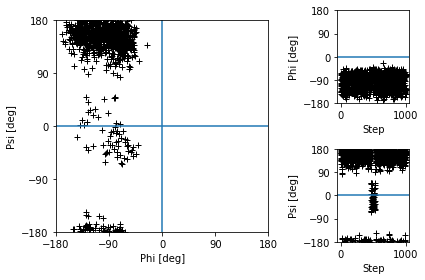

In [8]:
traj2 = mdtraj.load('traj2.dcd', top='alanine-dipeptide.prmtop')
plot_ramachandran(traj2)

## Explicit Solvent Simulations

In [11]:
pdb = PDBFile('alanine-dipeptide.pdb')
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)
print(modeller.topology)
# Write a PDB file to provide a topology of the solvated
# system to MDTraj below.
with open('init3.pdb', 'w') as outfile:
    PDBFile.writeFile(modeller.topology, modeller.positions, outfile)

# The modeller builds a periodic box with the solute and solvent molecules.
# PME is the method to compute long-range electristatic interactions in
# periodic systems.
system = forcefield.createSystem(
    modeller.topology, nonbondedMethod=PME, constraints=HBonds)
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1/picosecond, 2*femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()
'''
simulation.reporters.append(DCDReporter('traj3.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars3.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
'''
simulation.step(100000)

<Topology; 2 chains, 661 residues, 1996 atoms, 1337 bonds>
#"Step","Temperature (K)","Elapsed Time (s)"
1000,262.83382881919863,9.131431579589844e-05
2000,285.18645818628767,0.2373490333557129
3000,299.56401452968333,0.4724769592285156
4000,301.7906213256453,0.7090446949005127
5000,302.2267754283799,0.9504439830780029
6000,287.7583565153134,1.1927862167358398
7000,296.9606572642015,1.4373066425323486
8000,320.0953079202336,1.7328517436981201
9000,302.04366838213946,1.9823858737945557
10000,294.3629914097491,2.220136880874634
11000,314.0295013050865,2.4565649032592773
12000,293.9182496066103,2.696990489959717
13000,301.19345189184554,2.9469447135925293
14000,298.93555653957355,3.1952176094055176
15000,298.5426854645923,4.048005819320679
16000,310.251786234498,4.30790114402771
17000,298.2578853821763,4.555905818939209
18000,293.7839605031743,4.798627614974976
19000,295.7748634562903,5.040841579437256
20000,292.7006890718226,5.278913497924805
21000,293.7940720966518,5.518489122390747
2200

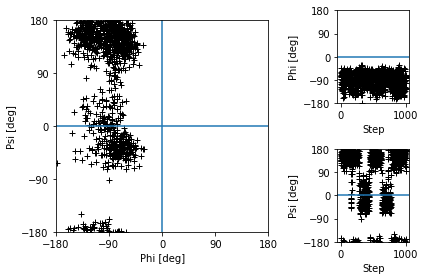

In [12]:
traj2 = mdtraj.load('traj2.dcd', top='alanine-dipeptide.prmtop')
plot_ramachandran(traj2)

In [13]:
traj3 = mdtraj.load('traj3.dcd', top='init3.pdb')
view = nglview.show_mdtraj(traj3)
view.clear_representations()
view.add_licorice()
view.add_unitcell()
view

NGLWidget(max_frame=999)

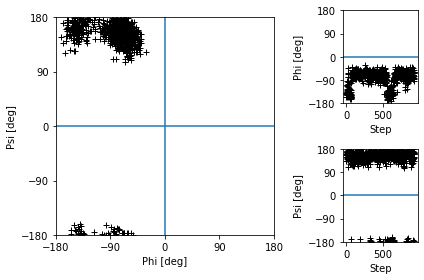

In [14]:
traj3.restrict_atoms(traj3.topology.select("protein"))
plot_ramachandran(traj3[75:])

Probably need to make a restraining potential for the intervals $[-100, 85]$ and $[-100, 85]^c$.

## References and Required Readings

http://ambermd.org/tutorials/advanced/tutorial19/ for that picture of alanine-dipeptide conformations

https://en.wikipedia.org/wiki/Water_model#:~:text=In%20computational%20chemistry%2C%20a%20water,experimental%20results%2C%20and%20these%20combinations.